In [203]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as tdist
import torch.utils.data
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import save_image
from tqdm import tqdm

In [204]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2, distribution="bernoulli"):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.distribution = distribution

        # Encoder network
        # Convolutional layers for Encoder
        self.conv1 = nn.Conv2d(
            1, 32, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 1, 28, 28) -> Output: (batch, 32, 14, 14)
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 32, 14, 14) -> Output: (batch, 64, 7, 7)
        # Fully connected layers to produce mu and logvar
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder network
        # Fully connected layer
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 64, 7, 7) -> Output: (batch, 32, 14, 14)
        self.deconv2 = nn.ConvTranspose2d(
            32, 1, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 32, 14, 14) -> Output: (batch, 1, 28, 28)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random tensor with same shape as std
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)  # Reshape
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)
        if self.distribution == "bernoulli":
            return torch.sigmoid(x)
        if self.distribution == "continuous_bernoulli":
            return torch.sigmoid(x)
        elif self.distribution == "gaussian":
            return torch.sigmoid(x)
        elif self.distribution == "gaussian_with_learned_variance":
            recon_mu = torch.sigmoid(x)
            recon_logvar = torch.sigmoid(x)
            # Apply softplus activation to ensure positive variance

            #        - **Unbounded `recon_logvar`**: The decoder outputs `recon_logvar` without any activation function, meaning it can take any real value, including large negative values.
            # - **Small Variance**: Large negative values of `recon_logvar` correspond to extremely small variances after applying the exponential function.
            # - **High PDF Values**: With very small variances, the Gaussian PDF becomes extremely peaked, leading to high values for `log_prob` when the input `x` is close to `recon_mu`.
            # - **Negative NLL**: This results in negative values for the NLL, which is unexpected since the NLL should be non-negative in practical scenarios.
            #   - **Softplus Function**: \( \text{softplus}(x) = \ln(1 + e^{x}) \), which outputs values greater than 0 for real inputs.
            # recon_logvar = F.softplus(recon_logvar)
            return recon_mu, recon_logvar
        else:
            raise ValueError("Invalid distribution")

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [205]:
# https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE
def sumlogC(x, eps=1e-5):
    """
    Numerically stable implementation of
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation

    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    """
    x = torch.clamp(x, eps, 1.0 - eps)
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values = torch.log((torch.log(1.0 - far) - torch.log(far)).div(1.0 - 2.0 * far))
    close_values = torch.log(torch.tensor((2.0))) + torch.log(
        1.0 + torch.pow(1.0 - 2.0 * close, 2) / 3.0
    )
    return far_values.sum() + close_values.sum()


In [206]:
def sumlogC_optimized(x, eps=1e-5):
    """
    Optimized numerically stable implementation of
    sum of logarithm of Continuous Bernoulli constant C,
    using Taylor 2nd degree approximation.

    Parameters
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    eps : float, optional
        Small value to prevent numerical instability near 0 and 1
    """
    # Clamp x to avoid issues with log(0)
    x = torch.clamp(x, eps, 1.0 - eps)

    # Compute mask for elements far from 0.5
    mask = torch.abs(x - 0.5) >= eps

    # Precompute constants
    log2 = torch.log(torch.tensor(2.0))
    one_minus_2x = 1.0 - 2.0 * x

    # Compute 'far_values' for elements where |x - 0.5| >= eps
    numerator = torch.log1p(-x) - torch.log(x)  # log(1 - x) - log(x)
    denominator = one_minus_2x
    far_values = torch.log(numerator / denominator)

    # Compute 'close_values' using Taylor approximation for elements where |x - 0.5| < eps
    close_values = log2 + torch.log(1.0 + (one_minus_2x**2) / 3.0)

    # Use torch.where to select appropriate values based on the mask
    values = torch.where(mask, far_values, close_values)

    # Return the sum of values
    return values.sum()


In [207]:
# this can be used for VAE2, VAE20, CBVAE_Mean
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # logC = sumlogC(recon_x)
    return BCE + KLD  # , logC


In [208]:
def vae2_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD


In [209]:
def KL_divergence(mu, logvar):
    q_z = tdist.Normal(loc=mu, scale=(0.5 * logvar).exp())
    p_z = tdist.Normal(loc=torch.zeros_like(mu), scale=torch.ones_like(logvar))
    KLD = tdist.kl_divergence(q_z, p_z).sum()
    return KLD


In [210]:
def cb_lambda_loss(recon_x, x, mu, logvar):
    tmp = tdist.ContinuousBernoulli(probs=recon_x)
    recon_x = tmp.mean
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    logC = sumlogC(recon_x)
    return BCE + KLD + logC


In [211]:
def gaussian_loss(recon_x, x, mu, logvar):
    batch_size = x.size(0)
    # Flatten recon_x and x to [batch_size, 784]
    recon_x = recon_x.view(batch_size, -1)
    x = x.view(batch_size, -1)

    # Reconstruction loss (assuming a fixed variance, can use MSE)
    MSE = F.mse_loss(recon_x, x, reduction="sum")
    # MSE /= batch_size  # Normalize by batch size

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [212]:
def loss_cont_gaussian(recon_x, x, mu, logvar):
    """
    Loss function for Gaussian vae
    Described by https://github.com/atinghosh/VAE-pytorch/blob/master/VAE_CNN_Gaussianloss.py
    """
    # x = x.view(-1, 784)
    mu_x, sigma = recon_x
    GLL = torch.sum(torch.log(sigma)) + 0.5 * torch.sum(((x - mu_x) / sigma).pow(2))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD + GLL

In [213]:
def beta_loss(alphas, betas, x, mu, logvar, beta_reg):
    x = x.view(-1, 784)
    recon_dist = tdist.Beta(alphas, betas)
    recon_x = recon_dist.mean
    recon_x = recon_x.view(-1, 784)
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD  # + logC


In [214]:
def loss_fct(recon_x, x, mu, logvar, distribution):
    if distribution == "bernoulli":
        return vae_loss(recon_x, x, mu, logvar)
    elif distribution == "continuous_bernoulli":
        return cb_lambda_loss(recon_x, x, mu, logvar)
    elif distribution == "gaussian":
        return gaussian_loss(recon_x, x, mu, logvar)
    elif distribution == "gaussian_with_learned_variance":
        return loss_cont_gaussian(recon_x, x, mu, logvar)

In [215]:
EPOCHS = 100
BATCH_SIZE = 128

torch.manual_seed(1);


## Check for GPU or MPS availability. Use CPU if neither is available


In [216]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")


Using device: mps


In [217]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data", train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data", train=False, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


In [218]:
def train(model, optimizer, loss_fn, epoch, distribution):
    model.train()
    train_loss = 0
    for _, (data, _) in enumerate(
        tqdm(
            train_loader,
            desc=f"Distribution: {distribution} - Training Epoch {epoch}/{EPOCHS}",
        )
    ):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_fn(recon_batch, data, mu, logvar, distribution)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    print(f"Epoch: {epoch} Average loss: {train_loss:.4f}")


In [219]:
def test(model, loss_fn, epoch, distribution):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(
            tqdm(
                test_loader,
                desc=f"Distribution: {distribution} - Test Epoch {epoch}/{EPOCHS}",
            )
        ):
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss = loss_fn(recon_batch, data, mu, logvar, distribution)
            test_loss += loss

            if i == 0:
                n = min(data.size(0), 8)
                if distribution == "gaussian_with_learned_variance":
                    recon_batch = recon_batch[0]
                recon_batch = recon_batch.view(128, 1, 28, 28)
                comparison = torch.cat([data[:n], recon_batch[:n]])

                save_image(
                    comparison.cpu(),
                    f"../images/{model.distribution}/reconstruction_"
                    + str(epoch)
                    + ".png",
                    nrow=n,
                )

    test_loss /= len(test_loader.dataset)
    print(f"Test set loss: {test_loss:.4f}")


In [202]:
latent_dim = 2


In [220]:
distributions = [
    # "gaussian_with_learned_variance",
    "gaussian",
    # "bernoulli",
    # "continuous_bernoulli",
]

for distribution in distributions:
    model = VAE(latent_dim=latent_dim, distribution=distribution).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, EPOCHS + 1):
        train(model, optimizer, loss_fct, epoch, model.distribution)
        test(model, loss_fct, epoch, model.distribution)
        if distribution != "gaussian_with_learned_variance":
            with torch.no_grad():
                sample = torch.randn(64, latent_dim).to(device)
                sample = model.decode(sample).cpu()
                save_image(
                    sample.view(64, 1, 28, 28),
                    f"../images/{model.distribution}/sample_" + str(epoch) + ".png",
                )

    timestr = time.strftime("%Y%m%d-%H%M%S")
    torch.save(model, f"../models/{model.distribution}_{timestr}.pt")


Distribution: gaussian - Training Epoch 1/100: 100%|██████████| 469/469 [00:06<00:00, 73.27it/s]


Epoch: 1 Average loss: 52.2084


Distribution: gaussian - Test Epoch 1/100: 100%|██████████| 79/79 [00:00<00:00, 178.56it/s]


Test set loss: 43.7873


Distribution: gaussian - Training Epoch 2/100: 100%|██████████| 469/469 [00:06<00:00, 76.47it/s]


Epoch: 2 Average loss: 42.7966


Distribution: gaussian - Test Epoch 2/100: 100%|██████████| 79/79 [00:00<00:00, 192.47it/s]


Test set loss: 42.2023


Distribution: gaussian - Training Epoch 3/100: 100%|██████████| 469/469 [00:05<00:00, 81.80it/s]


Epoch: 3 Average loss: 41.5138


Distribution: gaussian - Test Epoch 3/100: 100%|██████████| 79/79 [00:00<00:00, 184.48it/s]


Test set loss: 41.2620


Distribution: gaussian - Training Epoch 4/100: 100%|██████████| 469/469 [00:06<00:00, 76.11it/s]


Epoch: 4 Average loss: 40.8437


Distribution: gaussian - Test Epoch 4/100: 100%|██████████| 79/79 [00:00<00:00, 188.54it/s]


Test set loss: 40.6623


Distribution: gaussian - Training Epoch 5/100: 100%|██████████| 469/469 [00:05<00:00, 81.32it/s]


Epoch: 5 Average loss: 40.4003


Distribution: gaussian - Test Epoch 5/100: 100%|██████████| 79/79 [00:00<00:00, 178.18it/s]


Test set loss: 40.1907


Distribution: gaussian - Training Epoch 6/100: 100%|██████████| 469/469 [00:05<00:00, 81.81it/s]


Epoch: 6 Average loss: 40.1374


Distribution: gaussian - Test Epoch 6/100: 100%|██████████| 79/79 [00:00<00:00, 188.03it/s]


Test set loss: 40.0869


Distribution: gaussian - Training Epoch 7/100: 100%|██████████| 469/469 [00:05<00:00, 82.34it/s]


Epoch: 7 Average loss: 39.8940


Distribution: gaussian - Test Epoch 7/100: 100%|██████████| 79/79 [00:00<00:00, 189.02it/s]


Test set loss: 39.7910


Distribution: gaussian - Training Epoch 8/100: 100%|██████████| 469/469 [00:05<00:00, 80.45it/s]


Epoch: 8 Average loss: 39.7009


Distribution: gaussian - Test Epoch 8/100: 100%|██████████| 79/79 [00:00<00:00, 180.87it/s]


Test set loss: 39.6704


Distribution: gaussian - Training Epoch 9/100: 100%|██████████| 469/469 [00:05<00:00, 80.57it/s]


Epoch: 9 Average loss: 39.5353


Distribution: gaussian - Test Epoch 9/100: 100%|██████████| 79/79 [00:00<00:00, 188.18it/s]


Test set loss: 39.4525


Distribution: gaussian - Training Epoch 10/100: 100%|██████████| 469/469 [00:05<00:00, 80.40it/s]


Epoch: 10 Average loss: 39.4277


Distribution: gaussian - Test Epoch 10/100: 100%|██████████| 79/79 [00:00<00:00, 187.43it/s]


Test set loss: 39.5167


Distribution: gaussian - Training Epoch 11/100: 100%|██████████| 469/469 [00:05<00:00, 80.48it/s]


Epoch: 11 Average loss: 39.3150


Distribution: gaussian - Test Epoch 11/100: 100%|██████████| 79/79 [00:00<00:00, 176.67it/s]


Test set loss: 39.2625


Distribution: gaussian - Training Epoch 12/100: 100%|██████████| 469/469 [00:05<00:00, 80.80it/s]


Epoch: 12 Average loss: 39.1795


Distribution: gaussian - Test Epoch 12/100: 100%|██████████| 79/79 [00:00<00:00, 185.25it/s]


Test set loss: 39.1332


Distribution: gaussian - Training Epoch 13/100: 100%|██████████| 469/469 [00:05<00:00, 80.98it/s]


Epoch: 13 Average loss: 39.0869


Distribution: gaussian - Test Epoch 13/100: 100%|██████████| 79/79 [00:00<00:00, 187.81it/s]


Test set loss: 39.1451


Distribution: gaussian - Training Epoch 14/100: 100%|██████████| 469/469 [00:05<00:00, 80.56it/s]


Epoch: 14 Average loss: 38.9844


Distribution: gaussian - Test Epoch 14/100: 100%|██████████| 79/79 [00:00<00:00, 179.87it/s]


Test set loss: 39.2363


Distribution: gaussian - Training Epoch 15/100: 100%|██████████| 469/469 [00:05<00:00, 79.45it/s]


Epoch: 15 Average loss: 38.9199


Distribution: gaussian - Test Epoch 15/100: 100%|██████████| 79/79 [00:00<00:00, 184.86it/s]


Test set loss: 38.9546


Distribution: gaussian - Training Epoch 16/100: 100%|██████████| 469/469 [00:05<00:00, 80.01it/s]


Epoch: 16 Average loss: 38.8139


Distribution: gaussian - Test Epoch 16/100: 100%|██████████| 79/79 [00:00<00:00, 185.71it/s]


Test set loss: 38.8937


Distribution: gaussian - Training Epoch 17/100: 100%|██████████| 469/469 [00:05<00:00, 79.69it/s]


Epoch: 17 Average loss: 38.7523


Distribution: gaussian - Test Epoch 17/100: 100%|██████████| 79/79 [00:00<00:00, 176.52it/s]


Test set loss: 39.1391


Distribution: gaussian - Training Epoch 18/100: 100%|██████████| 469/469 [00:05<00:00, 79.05it/s]


Epoch: 18 Average loss: 38.6694


Distribution: gaussian - Test Epoch 18/100: 100%|██████████| 79/79 [00:00<00:00, 183.98it/s]


Test set loss: 38.6526


Distribution: gaussian - Training Epoch 19/100: 100%|██████████| 469/469 [00:05<00:00, 79.89it/s]


Epoch: 19 Average loss: 38.6104


Distribution: gaussian - Test Epoch 19/100: 100%|██████████| 79/79 [00:00<00:00, 185.32it/s]


Test set loss: 38.6782


Distribution: gaussian - Training Epoch 20/100: 100%|██████████| 469/469 [00:05<00:00, 79.10it/s]


Epoch: 20 Average loss: 38.5295


Distribution: gaussian - Test Epoch 20/100: 100%|██████████| 79/79 [00:00<00:00, 177.20it/s]


Test set loss: 38.4250


Distribution: gaussian - Training Epoch 21/100: 100%|██████████| 469/469 [00:05<00:00, 78.69it/s]


Epoch: 21 Average loss: 38.4939


Distribution: gaussian - Test Epoch 21/100: 100%|██████████| 79/79 [00:00<00:00, 186.88it/s]


Test set loss: 38.6141


Distribution: gaussian - Training Epoch 22/100: 100%|██████████| 469/469 [00:05<00:00, 79.17it/s]


Epoch: 22 Average loss: 38.4182


Distribution: gaussian - Test Epoch 22/100: 100%|██████████| 79/79 [00:00<00:00, 184.60it/s]


Test set loss: 38.4625


Distribution: gaussian - Training Epoch 23/100: 100%|██████████| 469/469 [00:05<00:00, 79.80it/s]


Epoch: 23 Average loss: 38.3820


Distribution: gaussian - Test Epoch 23/100: 100%|██████████| 79/79 [00:00<00:00, 177.97it/s]


Test set loss: 38.3984


Distribution: gaussian - Training Epoch 24/100: 100%|██████████| 469/469 [00:05<00:00, 79.42it/s]


Epoch: 24 Average loss: 38.3179


Distribution: gaussian - Test Epoch 24/100: 100%|██████████| 79/79 [00:00<00:00, 185.77it/s]


Test set loss: 38.4334


Distribution: gaussian - Training Epoch 25/100: 100%|██████████| 469/469 [00:05<00:00, 78.92it/s]


Epoch: 25 Average loss: 38.3033


Distribution: gaussian - Test Epoch 25/100: 100%|██████████| 79/79 [00:00<00:00, 183.32it/s]


Test set loss: 38.4094


Distribution: gaussian - Training Epoch 26/100: 100%|██████████| 469/469 [00:05<00:00, 79.01it/s]


Epoch: 26 Average loss: 38.2449


Distribution: gaussian - Test Epoch 26/100: 100%|██████████| 79/79 [00:00<00:00, 174.45it/s]


Test set loss: 38.4627


Distribution: gaussian - Training Epoch 27/100: 100%|██████████| 469/469 [00:05<00:00, 78.73it/s]


Epoch: 27 Average loss: 38.1849


Distribution: gaussian - Test Epoch 27/100: 100%|██████████| 79/79 [00:00<00:00, 183.74it/s]


Test set loss: 38.3682


Distribution: gaussian - Training Epoch 28/100: 100%|██████████| 469/469 [00:05<00:00, 79.63it/s]


Epoch: 28 Average loss: 38.1583


Distribution: gaussian - Test Epoch 28/100: 100%|██████████| 79/79 [00:00<00:00, 178.69it/s]


Test set loss: 38.2680


Distribution: gaussian - Training Epoch 29/100: 100%|██████████| 469/469 [00:05<00:00, 78.66it/s]


Epoch: 29 Average loss: 38.1079


Distribution: gaussian - Test Epoch 29/100: 100%|██████████| 79/79 [00:00<00:00, 186.34it/s]


Test set loss: 38.2582


Distribution: gaussian - Training Epoch 30/100: 100%|██████████| 469/469 [00:06<00:00, 78.06it/s]


Epoch: 30 Average loss: 38.0865


Distribution: gaussian - Test Epoch 30/100: 100%|██████████| 79/79 [00:00<00:00, 186.84it/s]


Test set loss: 38.1921


Distribution: gaussian - Training Epoch 31/100: 100%|██████████| 469/469 [00:05<00:00, 78.44it/s]


Epoch: 31 Average loss: 38.0558


Distribution: gaussian - Test Epoch 31/100: 100%|██████████| 79/79 [00:00<00:00, 176.56it/s]


Test set loss: 38.0873


Distribution: gaussian - Training Epoch 32/100: 100%|██████████| 469/469 [00:05<00:00, 78.50it/s]


Epoch: 32 Average loss: 38.0049


Distribution: gaussian - Test Epoch 32/100: 100%|██████████| 79/79 [00:00<00:00, 183.71it/s]


Test set loss: 38.2506


Distribution: gaussian - Training Epoch 33/100: 100%|██████████| 469/469 [00:05<00:00, 78.24it/s]


Epoch: 33 Average loss: 37.9742


Distribution: gaussian - Test Epoch 33/100: 100%|██████████| 79/79 [00:00<00:00, 186.61it/s]


Test set loss: 38.1285


Distribution: gaussian - Training Epoch 34/100: 100%|██████████| 469/469 [00:05<00:00, 78.98it/s]


Epoch: 34 Average loss: 37.9331


Distribution: gaussian - Test Epoch 34/100: 100%|██████████| 79/79 [00:00<00:00, 175.66it/s]


Test set loss: 38.0831


Distribution: gaussian - Training Epoch 35/100: 100%|██████████| 469/469 [00:06<00:00, 78.10it/s]


Epoch: 35 Average loss: 37.9242


Distribution: gaussian - Test Epoch 35/100: 100%|██████████| 79/79 [00:00<00:00, 184.45it/s]


Test set loss: 38.3174


Distribution: gaussian - Training Epoch 36/100: 100%|██████████| 469/469 [00:06<00:00, 77.49it/s]


Epoch: 36 Average loss: 37.8972


Distribution: gaussian - Test Epoch 36/100: 100%|██████████| 79/79 [00:00<00:00, 185.11it/s]


Test set loss: 38.0374


Distribution: gaussian - Training Epoch 37/100: 100%|██████████| 469/469 [00:06<00:00, 78.06it/s]


Epoch: 37 Average loss: 37.8496


Distribution: gaussian - Test Epoch 37/100: 100%|██████████| 79/79 [00:00<00:00, 177.06it/s]


Test set loss: 38.0186


Distribution: gaussian - Training Epoch 38/100: 100%|██████████| 469/469 [00:05<00:00, 78.35it/s]


Epoch: 38 Average loss: 37.8366


Distribution: gaussian - Test Epoch 38/100: 100%|██████████| 79/79 [00:00<00:00, 175.75it/s]


Test set loss: 38.0276


Distribution: gaussian - Training Epoch 39/100: 100%|██████████| 469/469 [00:05<00:00, 78.36it/s]


Epoch: 39 Average loss: 37.8167


Distribution: gaussian - Test Epoch 39/100: 100%|██████████| 79/79 [00:00<00:00, 184.23it/s]


Test set loss: 38.2832


Distribution: gaussian - Training Epoch 40/100: 100%|██████████| 469/469 [00:06<00:00, 78.08it/s]


Epoch: 40 Average loss: 37.7678


Distribution: gaussian - Test Epoch 40/100: 100%|██████████| 79/79 [00:00<00:00, 184.78it/s]


Test set loss: 38.4098


Distribution: gaussian - Training Epoch 41/100: 100%|██████████| 469/469 [00:05<00:00, 78.89it/s]


Epoch: 41 Average loss: 37.7449


Distribution: gaussian - Test Epoch 41/100: 100%|██████████| 79/79 [00:00<00:00, 175.17it/s]


Test set loss: 38.0011


Distribution: gaussian - Training Epoch 42/100: 100%|██████████| 469/469 [00:05<00:00, 78.87it/s]


Epoch: 42 Average loss: 37.7202


Distribution: gaussian - Test Epoch 42/100: 100%|██████████| 79/79 [00:00<00:00, 182.99it/s]


Test set loss: 38.1500


Distribution: gaussian - Training Epoch 43/100: 100%|██████████| 469/469 [00:06<00:00, 78.10it/s]


Epoch: 43 Average loss: 37.6922


Distribution: gaussian - Test Epoch 43/100: 100%|██████████| 79/79 [00:00<00:00, 183.30it/s]


Test set loss: 37.9601


Distribution: gaussian - Training Epoch 44/100: 100%|██████████| 469/469 [00:05<00:00, 78.46it/s]


Epoch: 44 Average loss: 37.6853


Distribution: gaussian - Test Epoch 44/100: 100%|██████████| 79/79 [00:00<00:00, 174.85it/s]


Test set loss: 38.2906


Distribution: gaussian - Training Epoch 45/100: 100%|██████████| 469/469 [00:05<00:00, 78.18it/s]


Epoch: 45 Average loss: 37.6514


Distribution: gaussian - Test Epoch 45/100: 100%|██████████| 79/79 [00:00<00:00, 184.36it/s]


Test set loss: 37.8793


Distribution: gaussian - Training Epoch 46/100: 100%|██████████| 469/469 [00:06<00:00, 77.85it/s]


Epoch: 46 Average loss: 37.6519


Distribution: gaussian - Test Epoch 46/100: 100%|██████████| 79/79 [00:00<00:00, 176.38it/s]


Test set loss: 37.9446


Distribution: gaussian - Training Epoch 47/100: 100%|██████████| 469/469 [00:06<00:00, 78.16it/s]


Epoch: 47 Average loss: 37.6356


Distribution: gaussian - Test Epoch 47/100: 100%|██████████| 79/79 [00:00<00:00, 184.72it/s]


Test set loss: 37.8010


Distribution: gaussian - Training Epoch 48/100: 100%|██████████| 469/469 [00:06<00:00, 78.08it/s]


Epoch: 48 Average loss: 37.6239


Distribution: gaussian - Test Epoch 48/100: 100%|██████████| 79/79 [00:00<00:00, 177.12it/s]


Test set loss: 37.9435


Distribution: gaussian - Training Epoch 49/100: 100%|██████████| 469/469 [00:06<00:00, 77.90it/s]


Epoch: 49 Average loss: 37.5842


Distribution: gaussian - Test Epoch 49/100: 100%|██████████| 79/79 [00:00<00:00, 186.27it/s]


Test set loss: 37.8504


Distribution: gaussian - Training Epoch 50/100: 100%|██████████| 469/469 [00:06<00:00, 78.15it/s]


Epoch: 50 Average loss: 37.5909


Distribution: gaussian - Test Epoch 50/100: 100%|██████████| 79/79 [00:00<00:00, 177.66it/s]


Test set loss: 38.0518


Distribution: gaussian - Training Epoch 51/100: 100%|██████████| 469/469 [00:05<00:00, 78.88it/s]


Epoch: 51 Average loss: 37.6110


Distribution: gaussian - Test Epoch 51/100: 100%|██████████| 79/79 [00:00<00:00, 184.36it/s]


Test set loss: 37.7876


Distribution: gaussian - Training Epoch 52/100: 100%|██████████| 469/469 [00:05<00:00, 78.33it/s]


Epoch: 52 Average loss: 37.5719


Distribution: gaussian - Test Epoch 52/100: 100%|██████████| 79/79 [00:00<00:00, 176.94it/s]


Test set loss: 37.8495


Distribution: gaussian - Training Epoch 53/100: 100%|██████████| 469/469 [00:06<00:00, 78.08it/s]


Epoch: 53 Average loss: 37.5195


Distribution: gaussian - Test Epoch 53/100: 100%|██████████| 79/79 [00:00<00:00, 187.61it/s]


Test set loss: 37.7522


Distribution: gaussian - Training Epoch 54/100: 100%|██████████| 469/469 [00:05<00:00, 78.63it/s]


Epoch: 54 Average loss: 37.5162


Distribution: gaussian - Test Epoch 54/100: 100%|██████████| 79/79 [00:00<00:00, 177.33it/s]


Test set loss: 37.8185


Distribution: gaussian - Training Epoch 55/100: 100%|██████████| 469/469 [00:06<00:00, 77.59it/s]


Epoch: 55 Average loss: 37.5307


Distribution: gaussian - Test Epoch 55/100: 100%|██████████| 79/79 [00:00<00:00, 182.25it/s]


Test set loss: 37.7950


Distribution: gaussian - Training Epoch 56/100: 100%|██████████| 469/469 [00:06<00:00, 77.03it/s]


Epoch: 56 Average loss: 37.4839


Distribution: gaussian - Test Epoch 56/100: 100%|██████████| 79/79 [00:00<00:00, 175.25it/s]


Test set loss: 37.7388


Distribution: gaussian - Training Epoch 57/100: 100%|██████████| 469/469 [00:06<00:00, 77.16it/s]


Epoch: 57 Average loss: 37.4701


Distribution: gaussian - Test Epoch 57/100: 100%|██████████| 79/79 [00:00<00:00, 182.38it/s]


Test set loss: 37.8278


Distribution: gaussian - Training Epoch 58/100: 100%|██████████| 469/469 [00:05<00:00, 78.32it/s]


Epoch: 58 Average loss: 37.4811


Distribution: gaussian - Test Epoch 58/100: 100%|██████████| 79/79 [00:00<00:00, 174.93it/s]


Test set loss: 37.7648


Distribution: gaussian - Training Epoch 59/100: 100%|██████████| 469/469 [00:06<00:00, 78.04it/s]


Epoch: 59 Average loss: 37.4336


Distribution: gaussian - Test Epoch 59/100: 100%|██████████| 79/79 [00:00<00:00, 186.52it/s]


Test set loss: 37.9199


Distribution: gaussian - Training Epoch 60/100: 100%|██████████| 469/469 [00:06<00:00, 77.58it/s]


Epoch: 60 Average loss: 37.4415


Distribution: gaussian - Test Epoch 60/100: 100%|██████████| 79/79 [00:00<00:00, 182.60it/s]


Test set loss: 37.7396


Distribution: gaussian - Training Epoch 61/100: 100%|██████████| 469/469 [00:05<00:00, 78.23it/s]


Epoch: 61 Average loss: 37.4222


Distribution: gaussian - Test Epoch 61/100: 100%|██████████| 79/79 [00:00<00:00, 176.85it/s]


Test set loss: 37.6770


Distribution: gaussian - Training Epoch 62/100: 100%|██████████| 469/469 [00:05<00:00, 78.37it/s]


Epoch: 62 Average loss: 37.4390


Distribution: gaussian - Test Epoch 62/100: 100%|██████████| 79/79 [00:00<00:00, 184.29it/s]


Test set loss: 38.0089


Distribution: gaussian - Training Epoch 63/100: 100%|██████████| 469/469 [00:05<00:00, 78.60it/s]


Epoch: 63 Average loss: 37.3867


Distribution: gaussian - Test Epoch 63/100: 100%|██████████| 79/79 [00:00<00:00, 182.83it/s]


Test set loss: 37.7807


Distribution: gaussian - Training Epoch 64/100: 100%|██████████| 469/469 [00:05<00:00, 78.63it/s]


Epoch: 64 Average loss: 37.3775


Distribution: gaussian - Test Epoch 64/100: 100%|██████████| 79/79 [00:00<00:00, 175.26it/s]


Test set loss: 38.3221


Distribution: gaussian - Training Epoch 65/100: 100%|██████████| 469/469 [00:06<00:00, 77.94it/s]


Epoch: 65 Average loss: 37.4179


Distribution: gaussian - Test Epoch 65/100: 100%|██████████| 79/79 [00:00<00:00, 183.17it/s]


Test set loss: 37.7878


Distribution: gaussian - Training Epoch 66/100: 100%|██████████| 469/469 [00:05<00:00, 79.45it/s]


Epoch: 66 Average loss: 37.3771


Distribution: gaussian - Test Epoch 66/100: 100%|██████████| 79/79 [00:00<00:00, 178.31it/s]


Test set loss: 37.6957


Distribution: gaussian - Training Epoch 67/100: 100%|██████████| 469/469 [00:05<00:00, 78.31it/s]


Epoch: 67 Average loss: 37.3631


Distribution: gaussian - Test Epoch 67/100: 100%|██████████| 79/79 [00:00<00:00, 185.50it/s]


Test set loss: 37.6816


Distribution: gaussian - Training Epoch 68/100: 100%|██████████| 469/469 [00:05<00:00, 78.82it/s]


Epoch: 68 Average loss: 37.3487


Distribution: gaussian - Test Epoch 68/100: 100%|██████████| 79/79 [00:00<00:00, 183.22it/s]


Test set loss: 37.5046


Distribution: gaussian - Training Epoch 69/100: 100%|██████████| 469/469 [00:06<00:00, 77.95it/s]


Epoch: 69 Average loss: 37.3363


Distribution: gaussian - Test Epoch 69/100: 100%|██████████| 79/79 [00:00<00:00, 176.68it/s]


Test set loss: 37.5619


Distribution: gaussian - Training Epoch 70/100: 100%|██████████| 469/469 [00:05<00:00, 78.84it/s]


Epoch: 70 Average loss: 37.3595


Distribution: gaussian - Test Epoch 70/100: 100%|██████████| 79/79 [00:00<00:00, 185.40it/s]


Test set loss: 37.6403


Distribution: gaussian - Training Epoch 71/100: 100%|██████████| 469/469 [00:06<00:00, 78.06it/s]


Epoch: 71 Average loss: 37.3167


Distribution: gaussian - Test Epoch 71/100: 100%|██████████| 79/79 [00:00<00:00, 187.39it/s]


Test set loss: 37.9343


Distribution: gaussian - Training Epoch 72/100: 100%|██████████| 469/469 [00:05<00:00, 79.40it/s]


Epoch: 72 Average loss: 37.3229


Distribution: gaussian - Test Epoch 72/100: 100%|██████████| 79/79 [00:00<00:00, 174.32it/s]


Test set loss: 38.0307


Distribution: gaussian - Training Epoch 73/100: 100%|██████████| 469/469 [00:05<00:00, 78.21it/s]


Epoch: 73 Average loss: 37.2860


Distribution: gaussian - Test Epoch 73/100: 100%|██████████| 79/79 [00:00<00:00, 186.25it/s]


Test set loss: 37.6815


Distribution: gaussian - Training Epoch 74/100: 100%|██████████| 469/469 [00:06<00:00, 77.73it/s]


Epoch: 74 Average loss: 37.2874


Distribution: gaussian - Test Epoch 74/100: 100%|██████████| 79/79 [00:00<00:00, 173.31it/s]


Test set loss: 37.6937


Distribution: gaussian - Training Epoch 75/100: 100%|██████████| 469/469 [00:05<00:00, 78.28it/s]


Epoch: 75 Average loss: 37.2915


Distribution: gaussian - Test Epoch 75/100: 100%|██████████| 79/79 [00:00<00:00, 185.64it/s]


Test set loss: 37.8370


Distribution: gaussian - Training Epoch 76/100: 100%|██████████| 469/469 [00:06<00:00, 78.14it/s]


Epoch: 76 Average loss: 37.2670


Distribution: gaussian - Test Epoch 76/100: 100%|██████████| 79/79 [00:00<00:00, 185.36it/s]


Test set loss: 37.7023


Distribution: gaussian - Training Epoch 77/100: 100%|██████████| 469/469 [00:06<00:00, 78.08it/s]


Epoch: 77 Average loss: 37.2985


Distribution: gaussian - Test Epoch 77/100: 100%|██████████| 79/79 [00:00<00:00, 178.53it/s]


Test set loss: 37.6635


Distribution: gaussian - Training Epoch 78/100: 100%|██████████| 469/469 [00:05<00:00, 78.81it/s]


Epoch: 78 Average loss: 37.2545


Distribution: gaussian - Test Epoch 78/100: 100%|██████████| 79/79 [00:00<00:00, 187.23it/s]


Test set loss: 37.8259


Distribution: gaussian - Training Epoch 79/100: 100%|██████████| 469/469 [00:05<00:00, 78.52it/s]


Epoch: 79 Average loss: 37.2364


Distribution: gaussian - Test Epoch 79/100: 100%|██████████| 79/79 [00:00<00:00, 186.35it/s]


Test set loss: 37.8024


Distribution: gaussian - Training Epoch 80/100: 100%|██████████| 469/469 [00:05<00:00, 79.13it/s]


Epoch: 80 Average loss: 37.2554


Distribution: gaussian - Test Epoch 80/100: 100%|██████████| 79/79 [00:00<00:00, 175.44it/s]


Test set loss: 37.5784


Distribution: gaussian - Training Epoch 81/100: 100%|██████████| 469/469 [00:05<00:00, 78.50it/s]


Epoch: 81 Average loss: 37.2354


Distribution: gaussian - Test Epoch 81/100: 100%|██████████| 79/79 [00:00<00:00, 186.52it/s]


Test set loss: 37.7487


Distribution: gaussian - Training Epoch 82/100: 100%|██████████| 469/469 [00:06<00:00, 78.01it/s]


Epoch: 82 Average loss: 37.2363


Distribution: gaussian - Test Epoch 82/100: 100%|██████████| 79/79 [00:00<00:00, 183.82it/s]


Test set loss: 37.7330


Distribution: gaussian - Training Epoch 83/100: 100%|██████████| 469/469 [00:05<00:00, 79.13it/s]


Epoch: 83 Average loss: 37.2020


Distribution: gaussian - Test Epoch 83/100: 100%|██████████| 79/79 [00:00<00:00, 186.40it/s]


Test set loss: 37.6331


Distribution: gaussian - Training Epoch 84/100: 100%|██████████| 469/469 [00:06<00:00, 78.05it/s]


Epoch: 84 Average loss: 37.2133


Distribution: gaussian - Test Epoch 84/100: 100%|██████████| 79/79 [00:00<00:00, 176.46it/s]


Test set loss: 37.6282


Distribution: gaussian - Training Epoch 85/100: 100%|██████████| 469/469 [00:05<00:00, 78.77it/s]


Epoch: 85 Average loss: 37.2153


Distribution: gaussian - Test Epoch 85/100: 100%|██████████| 79/79 [00:00<00:00, 187.95it/s]


Test set loss: 37.6227


Distribution: gaussian - Training Epoch 86/100: 100%|██████████| 469/469 [00:05<00:00, 78.75it/s]


Epoch: 86 Average loss: 37.1924


Distribution: gaussian - Test Epoch 86/100: 100%|██████████| 79/79 [00:00<00:00, 174.55it/s]


Test set loss: 37.5945


Distribution: gaussian - Training Epoch 87/100: 100%|██████████| 469/469 [00:05<00:00, 78.22it/s]


Epoch: 87 Average loss: 37.1775


Distribution: gaussian - Test Epoch 87/100: 100%|██████████| 79/79 [00:00<00:00, 183.38it/s]


Test set loss: 37.6033


Distribution: gaussian - Training Epoch 88/100: 100%|██████████| 469/469 [00:05<00:00, 78.26it/s]


Epoch: 88 Average loss: 37.1949


Distribution: gaussian - Test Epoch 88/100: 100%|██████████| 79/79 [00:00<00:00, 176.42it/s]


Test set loss: 37.6999


Distribution: gaussian - Training Epoch 89/100: 100%|██████████| 469/469 [00:06<00:00, 77.80it/s]


Epoch: 89 Average loss: 37.1674


Distribution: gaussian - Test Epoch 89/100: 100%|██████████| 79/79 [00:00<00:00, 185.68it/s]


Test set loss: 37.5643


Distribution: gaussian - Training Epoch 90/100: 100%|██████████| 469/469 [00:06<00:00, 74.67it/s]


Epoch: 90 Average loss: 37.1423


Distribution: gaussian - Test Epoch 90/100: 100%|██████████| 79/79 [00:00<00:00, 176.03it/s]


Test set loss: 37.5821


Distribution: gaussian - Training Epoch 91/100: 100%|██████████| 469/469 [00:06<00:00, 70.76it/s]


Epoch: 91 Average loss: 37.1474


Distribution: gaussian - Test Epoch 91/100: 100%|██████████| 79/79 [00:00<00:00, 176.60it/s]


Test set loss: 37.6278


Distribution: gaussian - Training Epoch 92/100: 100%|██████████| 469/469 [00:06<00:00, 72.95it/s]


Epoch: 92 Average loss: 37.1668


Distribution: gaussian - Test Epoch 92/100: 100%|██████████| 79/79 [00:00<00:00, 178.37it/s]


Test set loss: 37.6169


Distribution: gaussian - Training Epoch 93/100: 100%|██████████| 469/469 [00:07<00:00, 66.80it/s]


Epoch: 93 Average loss: 37.1548


Distribution: gaussian - Test Epoch 93/100: 100%|██████████| 79/79 [00:00<00:00, 177.06it/s]


Test set loss: 37.5691


Distribution: gaussian - Training Epoch 94/100: 100%|██████████| 469/469 [00:07<00:00, 66.94it/s]


Epoch: 94 Average loss: 37.1397


Distribution: gaussian - Test Epoch 94/100: 100%|██████████| 79/79 [00:00<00:00, 173.36it/s]


Test set loss: 37.4408


Distribution: gaussian - Training Epoch 95/100: 100%|██████████| 469/469 [00:07<00:00, 65.37it/s]


Epoch: 95 Average loss: 37.1123


Distribution: gaussian - Test Epoch 95/100: 100%|██████████| 79/79 [00:00<00:00, 184.40it/s]


Test set loss: 37.6258


Distribution: gaussian - Training Epoch 96/100: 100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch: 96 Average loss: 37.1331


Distribution: gaussian - Test Epoch 96/100: 100%|██████████| 79/79 [00:00<00:00, 182.65it/s]


Test set loss: 37.7388


Distribution: gaussian - Training Epoch 97/100: 100%|██████████| 469/469 [00:06<00:00, 67.82it/s]


Epoch: 97 Average loss: 37.1151


Distribution: gaussian - Test Epoch 97/100: 100%|██████████| 79/79 [00:00<00:00, 187.05it/s]


Test set loss: 37.4645


Distribution: gaussian - Training Epoch 98/100: 100%|██████████| 469/469 [00:08<00:00, 56.83it/s]


Epoch: 98 Average loss: 37.0981


Distribution: gaussian - Test Epoch 98/100: 100%|██████████| 79/79 [00:00<00:00, 186.35it/s]


Test set loss: 37.5839


Distribution: gaussian - Training Epoch 99/100: 100%|██████████| 469/469 [00:07<00:00, 64.17it/s]


Epoch: 99 Average loss: 37.1177


Distribution: gaussian - Test Epoch 99/100: 100%|██████████| 79/79 [00:00<00:00, 184.11it/s]


Test set loss: 37.5337


Distribution: gaussian - Training Epoch 100/100: 100%|██████████| 469/469 [00:06<00:00, 73.07it/s]


Epoch: 100 Average loss: 37.0930


Distribution: gaussian - Test Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 194.71it/s]

Test set loss: 37.5429


/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_58106/1154650953.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vae = torch.load("../models/bernoulli_

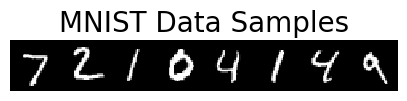

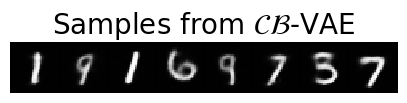

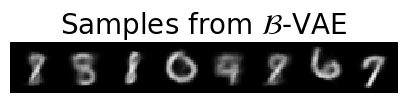

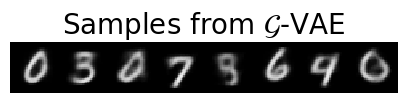

In [225]:
def imshow(img, title="MNIST Samples"):
    npimg = img.numpy()
    plt.figure(figsize=(5, 5))
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")


# Visualize dataset
dataiter = iter(test_loader)
mnist_images, mnist_labels = next(dataiter)


model_vae = VAE(latent_dim=latent_dim, distribution="bernoulli").to(device)
model_cbvae = VAE(latent_dim=latent_dim, distribution="continuous_bernoulli").to(device)
model_gvae = VAE(latent_dim=latent_dim, distribution="gaussian").to(device)


# Load models
model_vae = torch.load("../models/bernoulli_20250105-170534.pt")
model_cbvae = torch.load("../models/continuous_bernoulli_20250105-172440.pt")
model_gvae = torch.load("../models/gaussian_20250105-180253.pt")

# Sample from models
model_vae.eval()
model_cbvae.eval()
model_gvae.eval()

z = torch.randn(8, 2).to(device)
sample_cbvae = model_cbvae.decode(z).cpu().view(8, 1, 28, 28).detach()
sample_vae = model_vae.decode(z).cpu().view(8, 1, 28, 28).detach()
sample_gvae = model_gvae.decode(z).cpu().view(8, 1, 28, 28).detach()


# Plot
num_samples = 8
imshow(
    torchvision.utils.make_grid(mnist_images[:num_samples], num_samples),
    r"MNIST Data Samples",
)
imshow(
    torchvision.utils.make_grid(sample_cbvae[:num_samples], num_samples),
    r"Samples from $\mathcal{CB}$-VAE",
)
imshow(
    torchvision.utils.make_grid(sample_vae[:num_samples], num_samples),
    r"Samples from $\mathcal{B}$-VAE",
)
imshow(
    torchvision.utils.make_grid(sample_gvae[:num_samples], num_samples),
    r"Samples from $\mathcal{G}$-VAE",
)